In [2]:
#| default_exp datasets

In [5]:
#|export
from __future__ import annotations
import math,numpy as np,matplotlib.pyplot as plt
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch.utils.data import default_collate

from diy_stable_diffusion.training import *

In [5]:
import logging,pickle,gzip,os,time,shutil,torch,matplotlib as mpl
from pathlib import Path

from torch import tensor,nn,optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import load_dataset,load_dataset_builder

import torchvision.transforms.functional as TF
from fastcore.test import test_close

In [6]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [7]:
logging.disable(logging.WARNING)

# HF datasets

In [8]:
name = 'fashion_mnist'
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [9]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=10, names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [10]:
ds = load_dataset(name
                 )

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [12]:
ds['train']

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [13]:
model = nn.Sequential(nn.Linear(784, 100), nn.ReLU(), nn.Dropout(p=0.1), nn.Linear(100, 10))
opt = torch.optim.SGD(model.parameters(),lr=0.1)

In [14]:
from itertools import islice

In [15]:
train,test = ds['train'],ds['test']
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [16]:
x,y = ds_builder.info.features
x,y

('image', 'label')

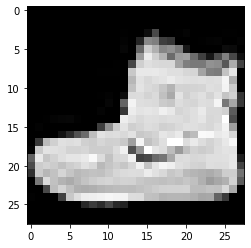

In [17]:
x,y='image','label'
img=train[0][x]
plt.imshow(img)

In [18]:
xb=train[:5][x]
yb=train[:5][y]
yb

[9, 0, 0, 3, 0]

In [19]:
featy = train.features[y]
featy

ClassLabel(num_classes=10, names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [20]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [21]:
train[y][:5],featy.int2str([3])

([9, 0, 0, 3, 0], ['Dress'])

In [22]:
x,y

('image', 'label')

In [23]:
def collate_fn(batch):
    return {
        'image': torch.stack([TF.to_tensor(ob['image']) for ob in batch]),
        'label': tensor([ob['label'] for ob in batch])
    }

In [24]:
ds_train=train
ds_valid=test

In [25]:
dl = DataLoader(ds_train, collate_fn=collate_fn, batch_size=16)
b=next(iter(dl))
b['image'].shape,b['label']

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [26]:
def transforms(b):
    b['image'] = [TF.to_tensor(o) for o in b['image']]
    return b

In [27]:
ds_train = ds_train.with_transform(transforms)
dl = DataLoader(ds_train, batch_size=16)

In [28]:
b = next(iter(dl))
b['image'].shape

torch.Size([16, 1, 28, 28])

In [29]:
def _transformi(b):
    b['image'] = [torch.flatten(TF.to_tensor(im)) for im in b['image']]


In [1]:
#|export
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [31]:
transformi = inplace(_transformi)

In [32]:
r = ds['train'].with_transform(transformi)[0]
r['image'].shape,r['label']

(torch.Size([784]), 9)

In [33]:
@inplace
def transformi(b):
    b['image'] = [torch.flatten(TF.to_tensor(im)) for im in b['image']]

In [34]:
ds= ds['train'].with_transform(transformi)


In [35]:
d=dict(a=1, b=2, c='c')
ig=itemgetter('a', 'c')
ig(d)

(1, 'c')

In [36]:
class D:
    def __getitem__(self, k):
        return 1 if k=='a' else 2
d=D()

In [37]:
d['a'],d['zzz']

(1, 2)

In [38]:
ig(d)

(1, 2)

In [39]:
tuple(ds.features)

('image', 'label')

In [40]:
b = dict(a=[1], b=[2]), dict(a=[3], b=[4])
default_collate(b)

{'a': [tensor([1, 3])], 'b': [tensor([2, 4])]}

In [41]:
#|export
def collate_dict(ds):
    getter = itemgetter(*ds.features)
    def _f(b):
        return getter(default_collate(b))
    return _f

In [42]:
d


In [43]:
f = collate_dict(ds)
f([next(iter(ds))])

(tensor([[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
          0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
          0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
          0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
          0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.29, 0.00, 0.00, 0.00, 0.02, 0.00, 0.00, 0.00, 0.00, 0.00,
          0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.00, 0.14, 0.53, 0.50, 0.24, 0.21, 0.00,
          0.00, 0.00, 0.00, 0.01, 0.02, 0.00, 0.00, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.02, 0.00,
      

In [44]:
dl = DataLoader(ds, batch_size=4, collate_fn=collate_dict(ds))
xb,yb=next(iter(dl))
xb.shape, yb

(torch.Size([4, 784]), tensor([9, 0, 0, 3]))

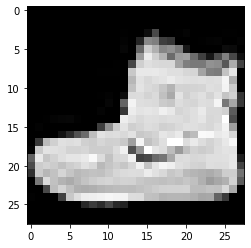

In [45]:
plt.imshow(xb[0].view(28,28))

In [2]:
#|export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    '''Show a PIL or pytorch tensor on ax'''
    if im is None:
        return None
    
    if fc.hasattrs(im, ('cpu', 'permute', 'detach')):
        im = im.detach().cpu()
        if len(im.shape) == 3 and im.shape[0] < 5:
            im = im.permute(1,2,0)
    elif not isinstance(im, np.ndarray):
        im = np.array(im)
    
    if im.shape[-1] == 1:
        im = im[...,0] # probably same as unsqueeze, right?
    if ax is None:
        _,ax = plt.subplots(figsize=figsize)

    ax.imshow(im, **kwargs)
    
    if title is not None:
        ax.set_title(title)
        
    ax.set_xticks([])
    ax.set_yticks([])
    
    if noframe:
        ax.axis('off')
    return ax

NameError: name 'fc' is not defined

<AxesSubplot:>

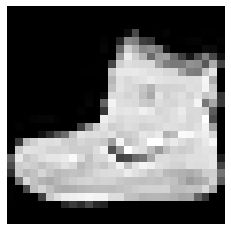

In [47]:
show_image(xb[0].view(28,28))

In [48]:
def rs(s):
    return s.view(28,28)

<AxesSubplot:>

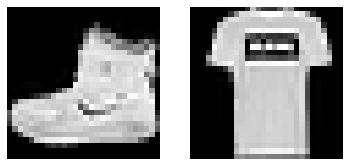

In [49]:
fig,axs = plt.subplots(1,2)
show_image(rs(xb[0]), axs[0])
show_image(rs(xb[1]), axs[1])

In [50]:
!pip install nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 829.2 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.9 MB/s eta 0:00:00


In [51]:
from nbdev.showdoc import show_doc

In [52]:
show_doc(show_image)

/usr/local/lib/python3.9/dist-packages/fastcore/docscrape.py:225: UserWarning: Unknown section Other Parameters
  else: warn(msg)
/usr/local/lib/python3.9/dist-packages/fastcore/docscrape.py:225: UserWarning: Unknown section See Also
  else: warn(msg)
/usr/local/lib/python3.9/dist-packages/fastcore/docscrape.py:225: UserWarning: Unknown section Notes
  else: warn(msg)


---

### show_image

>      show_image (im, ax=None, figsize=None, title=None, noframe=True,
>                  cmap=None, norm=None, aspect=None, interpolation=None,
>                  alpha=None, vmin=None, vmax=None, origin=None, extent=None,
>                  interpolation_stage=None, filternorm=True, filterrad=4.0,
>                  resample=None, url=None, data=None)

Show a PIL or pytorch tensor on ax

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| im |  |  |  |
| ax | NoneType | None |  |
| figsize | NoneType | None |  |
| title | NoneType | None |  |
| noframe | bool | True |  |
| cmap | NoneType | None | The Colormap instance or registered colormap name used to map<br>scalar data to colors. This parameter is ignored for RGB(A) data. |
| norm | NoneType | None | The `.Normalize` instance used to scale scalar data to the [0, 1]<br>range before mapping to colors using *cmap*. By default, a linear<br>scaling mapping the lowest value to 0 and the highest to 1 is used.<br>This parameter is ignored for RGB(A) data. |
| aspect | NoneType | None | The aspect ratio of the Axes.  This parameter is particularly<br>relevant for images since it determines whether data pixels are<br>square.<br><br>This parameter is a shortcut for explicitly calling<br>`.Axes.set_aspect`. See there for further details.<br><br>- 'equal': Ensures an aspect ratio of 1. Pixels will be square<br>  (unless pixel sizes are explicitly made non-square in data<br>  coordinates using *extent*).<br>- 'auto': The Axes is kept fixed and the aspect is adjusted so<br>  that the data fit in the Axes. In general, this will result in<br>  non-square pixels. |
| interpolation | NoneType | None | The interpolation method used.<br><br>Supported values are 'none', 'antialiased', 'nearest', 'bilinear',<br>'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite',<br>'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell',<br>'sinc', 'lanczos', 'blackman'.<br><br>If *interpolation* is 'none', then no interpolation is performed<br>on the Agg, ps, pdf and svg backends. Other backends will fall back<br>to 'nearest'. Note that most SVG renderers perform interpolation at<br>rendering and that the default interpolation method they implement<br>may differ.<br><br>If *interpolation* is the default 'antialiased', then 'nearest'<br>interpolation is used if the image is upsampled by more than a<br>factor of three (i.e. the number of display pixels is at least<br>three times the size of the data array).  If the upsampling rate is<br>smaller than 3, or the image is downsampled, then 'hanning'<br>interpolation is used to act as an anti-aliasing filter, unless the<br>image happens to be upsampled by exactly a factor of two or one.<br><br>See<br>:doc:`/gallery/images_contours_and_fields/interpolation_methods`<br>for an overview of the supported interpolation methods, and<br>:doc:`/gallery/images_contours_and_fields/image_antialiasing` for<br>a discussion of image antialiasing.<br><br>Some interpolation methods require an additional radius parameter,<br>which can be set by *filterrad*. Additionally, the antigrain image<br>resize filter is controlled by the parameter *filternorm*. |
| alpha | NoneType | None | The alpha blending value, between 0 (transparent) and 1 (opaque).<br>If *alpha* is an array, the alpha blending values are applied pixel<br>by pixel, and *alpha* must have the same shape as *X*. |
| vmin | NoneType | None |  |
| vmax | NoneType | None |  |
| origin | NoneType | None | Place the [0, 0] index of the array in the upper left or lower<br>left corner of the Axes. The convention (the default) 'upper' is<br>typically used for matrices and images.<br><br>Note that the vertical axis points upward for 'lower'<br>but downward for 'upper'.<br><br>See the :doc:`/tutorials/intermediate/imshow_extent` tutorial for<br>examples and a more detailed description. |
| extent | NoneType | None | The bounding box in data coordinates that the image will fill.<br>The image is stretched individually along x and y to fill the box.<br><br>The default extent is determined by the following conditions.<br>Pixels have unit size in data coordinates. Their centers are on<br>integer coordinates, and their center coordinates range from 0 to<br>columns-1 horizontally and from 0 to rows-1 vertically.<br><br>Note that the direction of the vertical axis and thus the default<br>values for top and bottom depend on *origin*:<br><br>- For ``origin == 'upper'`` the default is<br>  ``(-0.5, numcols-0.5, numrows-0.5, -0.5)``.<br>- For ``origin == 'lower'`` the default is<br>  ``(-0.5, numcols-0.5, -0.5, numrows-0.5)``.<br><br>See the :doc:`/tutorials/intermediate/imshow_extent` tutorial for<br>examples and a more detailed description. |
| interpolation_stage | NoneType | None | If 'data', interpolation<br>is carried out on the data provided by the user.  If 'rgba', the<br>interpolation is carried out after the colormapping has been<br>applied (visual interpolation). |
| filternorm | bool | True | A parameter for the antigrain image resize filter (see the<br>antigrain documentation).  If *filternorm* is set, the filter<br>normalizes integer values and corrects the rounding errors. It<br>doesn't do anything with the source floating point values, it<br>corrects only integers according to the rule of 1.0 which means<br>that any sum of pixel weights must be equal to 1.0.  So, the<br>filter function must produce a graph of the proper shape. |
| filterrad | float | 4.0 | The filter radius for filters that have a radius parameter, i.e.<br>when interpolation is one of: 'sinc', 'lanczos' or 'blackman'. |
| resample | NoneType | None | When *True*, use a full resampling method.  When *False*, only<br>resample when the output image is larger than the input image. |
| url | NoneType | None | Set the url of the created `.AxesImage`. See `.Artist.set_url`. |
| data | NoneType | None |  |

In [53]:
#|export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1,
    ncols:int=1,
    figsize:tuple=None,
    imsize:int=3, # in inches
    suptitle:str=None,
    **kwargs
):
    if figsize is None:
        figsize = (ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)

    if suptitle is not None:
        fig.suptitle(suptitle)

    if nrows * ncols == 1:
        ax = np.array([ax])
    return fig, ax

In [54]:
xb,yb = train[:16]['image'],train[:16]['label']

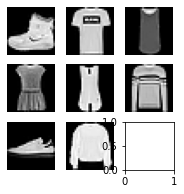

In [55]:
fig,axs = subplots(3,3, imsize=1)
imgs = xb[:8]
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

In [1]:
#|export
def get_grid(
    n:int, 
    nrows:int=None,
    ncols:int=None,
    title:str=None,
    weight:str='bold',
    size:int=14,
    **kwargs,
):
    if nrows:
        ncols = ncols or int(np.ceil(n/nrows))
    elif ncols:
        nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n/nrows))
    fig, axes = subplots(nrows, ncols, **kwargs)
    
    for i in range(n, nrows * ncols):
        axes.flat[i].set_axis_off()
    
    if title is not None:
        fig.suptitle(title, weight=weight, size=size)
    
    return fig, axes
    

8


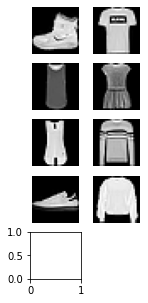

In [57]:
f,axes = get_grid(9, nrows=5, imsize=1)
for ax, im in zip(axes.flat, imgs):
    show_image(im, ax)
print(len(imgs))

In [58]:
tuple(zip_longest([1, 2, 3, 4], ['a', 'b', 'c', 'd', 'e'], ['A', 'B']))

((1, 'a', 'A'),
 (2, 'b', 'B'),
 (3, 'c', None),
 (4, 'd', None),
 (None, 'e', None))

In [59]:
#|export
@fc.delegates(subplots)
def show_images(ims:list,
                nrows:int|None=None,
                ncols:int|None=None,
                titles:list|None=None,
                **kwargs):
    axes = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im, title, ax in zip_longest(ims, titles or [], axes):
        show_image(im, ax=ax, title=title)

In [60]:
labels = featy.int2str(yb)

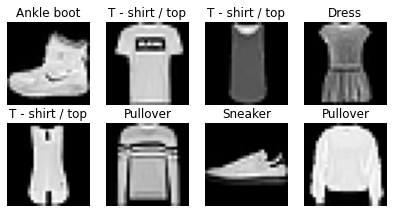

In [61]:
show_images(imgs, imsize=1.7, titles=labels[:8])

In [62]:
get_dls??

Signature: get_dls(train_ds, valid_ds, bs, **kwargs)
Docstring: <no docstring>
Source:   
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))
File:      /usr/local/lib/python3.9/dist-packages/miniai/training.py
Type:      function


In [1]:
#|export
class DataLoaders:
    def __init__(self, dl_train, dl_valid):
        self.train = dl_train
        self.valid = dl_valid
    
    @classmethod
    def from_dd(cls, ds_dict, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(ds_dict['train'])
        return cls(*get_dls(*ds_dict.values(), bs=batch_size, collate_fn=f, **kwargs))

In [3]:
! pip install nbdev

In [3]:
import nbdev; nbdev.nbdev_export()